In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()         
        )
        
        # mu cov in latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # decoder bernoulli
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  
        )
        
        # decoder gaussian
        # self.decoder_mean = nn.Sequential(
        #     nn.Linear(latent_dim, hidden_dim),
        #     nn.ReLU(),
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.ReLU(),
        #     nn.Linear(hidden_dim, input_dim),
        #     nn.Tanh()
        # )

        # self.decoder_logvar = nn.Sequential(
        #     nn.Linear(latent_dim, hidden_dim),
        #     nn.ReLU(),
        #     nn.Linear(hidden_dim, input_dim)
        # )

        # def decode(self, z):
        #     return self.decoder_mean(z), self.decoder_logvar(z)
        
    # encode as a function
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    # decode as a function
    def decode(self, z):
        return self.decoder(z)
    
    # reparameterize (for compute Gd of the encoder)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# a flexible loss (but not that general) 
class ModernVAELoss(nn.Module):
    def __init__(self, 
                 recon_type='bernoulli', 
                 beta=1.0, 
                 sigma=1.0,
                 free_bits=0.0,
                 learn_variance=False,
                 reduction='mean'):
        super().__init__()
        self.recon_type = recon_type
        self.beta = beta
        self.sigma = sigma
        self.free_bits = free_bits
        self.learn_variance = learn_variance
        self.reduction = reduction
    
    def reconstruction_loss(self, recon_params, x):
        if self.learn_variance:
            if self.recon_type == 'gaussian':
                mean, logvar = recon_params
                return 0.5 * torch.sum(
                    logvar + (x - mean).pow(2) / logvar.exp() + 
                    torch.log(2 * torch.pi),
                dim=-1
            )
            elif self.recon_type == 'bernoulli':
                logits = recon_params[0]
                return F.binary_cross_entropy_with_logits(
                    logits, x, reduction='none'
                ).sum(dim=-1)
        else:
            if self.recon_type == 'bernoulli':
                return F.binary_cross_entropy(
                    recon_params, x, reduction='none'
                ).sum(dim=-1)
            elif self.recon_type == 'gaussian':
                return 0.5 * (x - recon_params).pow(2).sum(dim=-1) / (self.sigma**2)
    
    def kld_loss(self, mu, logvar):
        kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        kl = torch.sum(kl, dim=-1)
        
        if self.free_bits > 0:
            kl = torch.max(kl, kl.new_full(kl.size(), self.free_bits))
        
        return kl
    
    def forward(self, recon_params, x, mu, logvar, beta=None):
        beta = self.beta if beta is None else beta
        
        # 展平输入
        x_flat = x.view(x.size(0), -1)
        
        # 计算损失
        recon_loss = self.reconstruction_loss(recon_params, x_flat)
        kld = self.kld_loss(mu, logvar)
        
        total_loss = recon_loss + beta * kld
        
        if self.reduction == 'sum':
            return total_loss.sum()
        elif self.reduction == 'mean':
            return total_loss.mean()
        else:
            return total_loss              

100%|██████████| 469/469 [00:09<00:00, 50.50it/s]


Epoch 1: Average loss: 1.2636


100%|██████████| 469/469 [00:09<00:00, 51.61it/s]


Epoch 2: Average loss: 0.9913


100%|██████████| 469/469 [00:09<00:00, 50.12it/s]


Epoch 3: Average loss: 0.9518


100%|██████████| 469/469 [00:09<00:00, 51.02it/s]


Epoch 4: Average loss: 0.9361


100%|██████████| 469/469 [00:09<00:00, 50.61it/s]


Epoch 5: Average loss: 0.9262


100%|██████████| 469/469 [00:09<00:00, 51.13it/s]


Epoch 6: Average loss: 0.9133


100%|██████████| 469/469 [00:09<00:00, 50.88it/s]


Epoch 7: Average loss: 0.9047


100%|██████████| 469/469 [00:09<00:00, 51.94it/s]


Epoch 8: Average loss: 0.8984


100%|██████████| 469/469 [00:08<00:00, 53.73it/s]


Epoch 9: Average loss: 0.8921


100%|██████████| 469/469 [00:08<00:00, 54.32it/s]


Epoch 10: Average loss: 0.8892


100%|██████████| 469/469 [00:08<00:00, 54.67it/s]


Epoch 11: Average loss: 0.8848


100%|██████████| 469/469 [00:08<00:00, 52.30it/s]


Epoch 12: Average loss: 0.8805


100%|██████████| 469/469 [00:08<00:00, 53.16it/s]


Epoch 13: Average loss: 0.8765


100%|██████████| 469/469 [00:08<00:00, 52.86it/s]


Epoch 14: Average loss: 0.8731


100%|██████████| 469/469 [00:09<00:00, 51.96it/s]


Epoch 15: Average loss: 0.8709


100%|██████████| 469/469 [00:09<00:00, 52.05it/s]


Epoch 16: Average loss: 0.8687


100%|██████████| 469/469 [00:08<00:00, 53.27it/s]


Epoch 17: Average loss: 0.8674


100%|██████████| 469/469 [00:08<00:00, 52.36it/s]


Epoch 18: Average loss: 0.8663


100%|██████████| 469/469 [00:08<00:00, 52.57it/s]


Epoch 19: Average loss: 0.8647


100%|██████████| 469/469 [00:08<00:00, 52.32it/s]


Epoch 20: Average loss: 0.8631


100%|██████████| 469/469 [00:09<00:00, 52.08it/s]


Epoch 21: Average loss: 0.8618


100%|██████████| 469/469 [00:09<00:00, 48.86it/s]


Epoch 22: Average loss: 0.8623


100%|██████████| 469/469 [00:09<00:00, 51.55it/s]


Epoch 23: Average loss: 0.8601


100%|██████████| 469/469 [00:09<00:00, 50.64it/s]


Epoch 24: Average loss: 0.8604


100%|██████████| 469/469 [00:09<00:00, 51.89it/s]


Epoch 25: Average loss: 0.8594


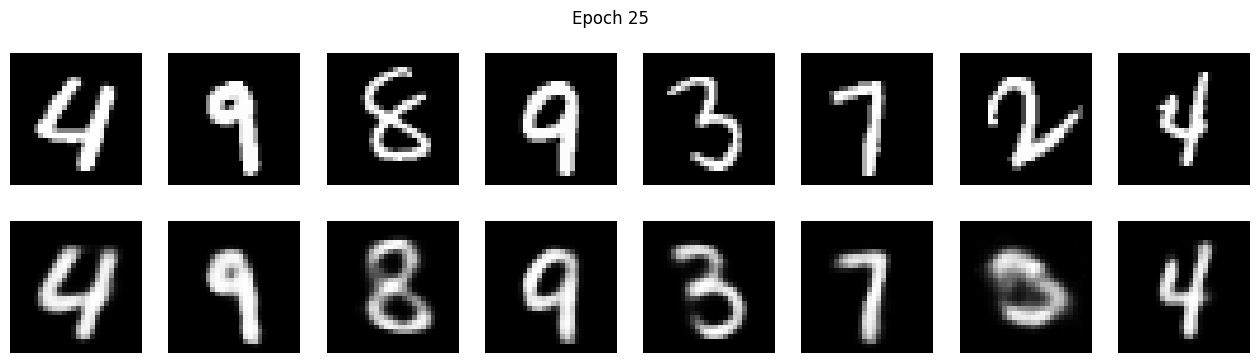

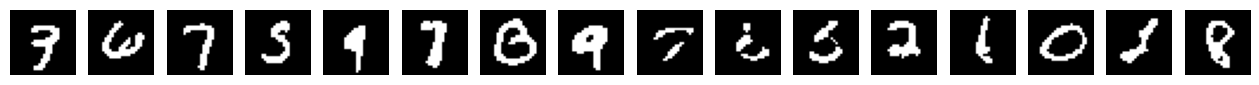

In [8]:
# main

# params
input_dim = 784  # MNIST 图像大小 28x28=784
hidden_dim = 400
latent_dim = 20
batch_size = 128
epochs = 25
learning_rate = 0.005
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data operation
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)

# init and optim
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = ModernVAELoss(recon_type='bernoulli', beta=1.0)

# train
train_losses = []
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = loss_fn(recon_batch, data.view(-1, 784), mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    avg_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch}: Average loss: {avg_loss:.4f}')

# showshow
def plot_results(epoch):
    """显示原始图像和重构图像"""
    model.eval()
    with torch.no_grad():
        
        test_loader = DataLoader(
            datasets.MNIST('./data', train=False, transform=transform),
            batch_size=16, shuffle=True
        )
        data, _ = next(iter(test_loader))
        data = data.to(device)
        
        recon, _, _ = model(data)
        
        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            axes[0, i].imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(recon[i].cpu().view(28, 28).numpy(), cmap='gray')
            axes[1, i].axis('off')
        plt.suptitle(f'Epoch {epoch}')
        plt.show()

def generate_samples(num_samples=16):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z).cpu()
        threshold = 0.5
        binary_samples = (samples > threshold).float()
        fig, axes = plt.subplots(1, num_samples, figsize=(16, 2))
        for i, ax in enumerate(axes):
            ax.imshow(binary_samples[i].view(28, 28).numpy(), cmap='gray')
            ax.axis('off')
        plt.show()


plot_results(epochs)
generate_samples()